# U-net network for multi-image segmentations

![](u-net-architecture.png)

In [1]:
import tensorflow as tf
import pickle
import glob
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np
from keras.utils import normalize

In [2]:
#shape of our training images
img_h = 128 
img_w = 128

In [3]:
lc = "train/*" # images location
folder_train = sorted(glob.glob(lc)) # create a list wich is containg image locations
#same prosedure for masked images
lca = "trainannot/*"
folder_mask = sorted(glob.glob(lca))

training_img = []
train_masks = [] 

for loc in folder_train:
    img = cv2.imread(loc,0) #reading each image by location
    img_size = cv2.resize(img, (img_h, img_w)) # resizing it for our model
    training_img.append(img_size) # adding image arrays in oour list

# same as traning ...
for loca in folder_mask:
    imga = cv2.imread(loca,0)
    img_sizea = cv2.resize(imga, (img_h, img_w))
    train_masks.append(img_sizea)
    


training_img = np.array(training_img)
train_masks = np.array(train_masks)



training_img = np.expand_dims(training_img, axis=3) # Expand the shape of an array
training_img = normalize(training_img, axis=1)

train_masks_input = np.expand_dims(train_masks, axis=3)

X_train, X_test, y_train, y_test = train_test_split(training_img, train_masks_input, test_size = 0.2, random_state = 0)

n_class = len(np.unique(y_train))  #or len(np.unique(y_test))

train_masks_cat = to_categorical(y_train, num_classes=n_class)  # prosedur for multi class
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_class)) # makeing dataset shape ready for training - n_class our multi class values

test_masks_cat = to_categorical(y_test, num_classes=n_class)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_class))

In [4]:
img_c = 1 # gray chanels

In [10]:
inputs = tf.keras.layers.Input((img_h,img_w,img_c))
s = tf.keras.layers.Lambda(lambda x: x/255)(inputs)

#network left side of U -net
c1 = tf.keras.layers.Conv2D(16,(3,3),kernel_initializer='he_normal',padding="same",activation="relu")(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16,(3,3),kernel_initializer='he_normal',padding="same",activation="relu")(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)


c2 = tf.keras.layers.Conv2D(32,(3,3),kernel_initializer='he_normal',padding="same",activation="relu")(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32,(3,3),kernel_initializer='he_normal',padding="same",activation="relu")(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64,(3,3),kernel_initializer='he_normal',padding="same",activation="relu")(p2)
c3 = tf.keras.layers.Dropout(0.1)(c3)
c3 = tf.keras.layers.Conv2D(64,(3,3),kernel_initializer='he_normal',padding="same",activation="relu")(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)


c4 = tf.keras.layers.Conv2D(128,(3,3),kernel_initializer='he_normal',padding="same",activation="relu")(p3)
c4 = tf.keras.layers.Dropout(0.1)(c4)
c4 = tf.keras.layers.Conv2D(128,(3,3),kernel_initializer='he_normal',padding="same",activation="relu")(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256,(3,3),kernel_initializer='he_normal',padding="same",activation="relu")(p4)
c5 = tf.keras.layers.Dropout(0.1)(c5)
c5 = tf.keras.layers.Conv2D(256,(3,3),kernel_initializer='he_normal',padding="same",activation="relu")(c5)
p5 = tf.keras.layers.MaxPooling2D((2,2))(c5)
# bottom side of network u net 
c6 = tf.keras.layers.Conv2D(512,(3,3),kernel_initializer='he_normal',padding="same",activation="relu")(p5)
c6 = tf.keras.layers.Dropout(0.1)(c6)
c6 = tf.keras.layers.Conv2D(512,(4,4),kernel_initializer='he_normal',padding="same",activation="relu")(c6)

# right side of U net
u7 = tf.keras.layers.Conv2DTranspose(64,(2,2),strides=(2,2),padding="same")(c6)
u7 = tf.keras.layers.concatenate([u7,c5])
c7 = tf.keras.layers.Conv2D(256,(3,3),kernel_initializer='he_normal',padding="same",activation="relu")(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(256,(3,3),kernel_initializer='he_normal',padding="same",activation="relu")(c7)


u8 = tf.keras.layers.Conv2DTranspose(128,(2,2),strides=(2,2),padding="same")(c7)
u8 = tf.keras.layers.concatenate([u8,c4])
c8 = tf.keras.layers.Conv2D(128,(3,3),kernel_initializer='he_normal',padding="same",activation="relu")(u8)
c8 = tf.keras.layers.Dropout(0.2)(c8)
c8 = tf.keras.layers.Conv2D(128,(3,3),kernel_initializer='he_normal',padding="same",activation="relu")(c8)

u9 = tf.keras.layers.Conv2DTranspose(64,(2,2),strides=(2,2),padding="same")(c8)
u9 = tf.keras.layers.concatenate([u9,c3])
c9 = tf.keras.layers.Conv2D(64,(3,3),kernel_initializer='he_normal',padding="same",activation="relu")(u9)
c9 = tf.keras.layers.Dropout(0.2)(c9)
c9 = tf.keras.layers.Conv2D(64,(3,3),kernel_initializer='he_normal',padding="same",activation="relu")(c9)

u10 = tf.keras.layers.Conv2DTranspose(32,(2,2),strides=(2,2),padding="same")(c9)
u10 = tf.keras.layers.concatenate([u10,c2])
c10 = tf.keras.layers.Conv2D(32,(3,3),kernel_initializer='he_normal',padding="same",activation="relu")(u10)
c10 = tf.keras.layers.Dropout(0.2)(c10)
c10 = tf.keras.layers.Conv2D(32,(3,3),kernel_initializer='he_normal',padding="same",activation="relu")(c10)

u11 = tf.keras.layers.Conv2DTranspose(16,(2,2),strides=(2,2),padding="same")(c10)
u11 = tf.keras.layers.concatenate([u11,c1],axis=3)
c11 = tf.keras.layers.Conv2D(16,(3,3),kernel_initializer='he_normal',padding="same",activation="relu")(u11)
c11 = tf.keras.layers.Dropout(0.1)(c11)
c11 = tf.keras.layers.Conv2D(16,(3,3),kernel_initializer='he_normal',padding="same",activation="relu")(c11)

In [11]:
outputs = tf.keras.layers.Conv2D(n_class,(1,1),activation="sigmoid")(c11)
model = tf.keras.Model(inputs = [inputs],outputs=[outputs])

In [12]:
model.compile(optimizer='adam',loss="categorical_crossentropy",metrics=['accuracy'])

In [13]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 128, 128, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_11 (Dropout)            (None, 128, 128, 16) 0           conv2d_23[0][0]                  
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 128, 128, 16) 2320        dropout_11[0][0]                 
____________________________________________________________________________________________

In [14]:
history = model.fit(X_train, y_train_cat,
                    batch_size = 16,
                    epochs=50,
                    validation_data=(X_test, y_test_cat),
                    shuffle=False)

Epoch 1/50
19/19 [==============================] - 49s 2s/step - loss: 2.2910 - accuracy: 0.2009 - val_loss: 2.0572 - val_accuracy: 0.2996
Epoch 2/50
19/19 [==============================] - 47s 2s/step - loss: 2.0198 - accuracy: 0.2913 - val_loss: 1.8148 - val_accuracy: 0.3291
Epoch 3/50
19/19 [==============================] - 47s 2s/step - loss: 1.7518 - accuracy: 0.3568 - val_loss: 1.4650 - val_accuracy: 0.4869
Epoch 4/50
19/19 [==============================] - 47s 2s/step - loss: 1.4248 - accuracy: 0.5463 - val_loss: 1.3431 - val_accuracy: 0.5477
Epoch 5/50
19/19 [==============================] - 47s 2s/step - loss: 1.2636 - accuracy: 0.6247 - val_loss: 1.3794 - val_accuracy: 0.5974
Epoch 6/50
19/19 [==============================] - 47s 2s/step - loss: 1.1198 - accuracy: 0.6612 - val_loss: 1.0571 - val_accuracy: 0.6681
Epoch 7/50
19/19 [==============================] - 47s 2s/step - loss: 1.0554 - accuracy: 0.6724 - val_loss: 1.0761 - val_accuracy: 0.6624
Epoch 8/50
19/19 [==

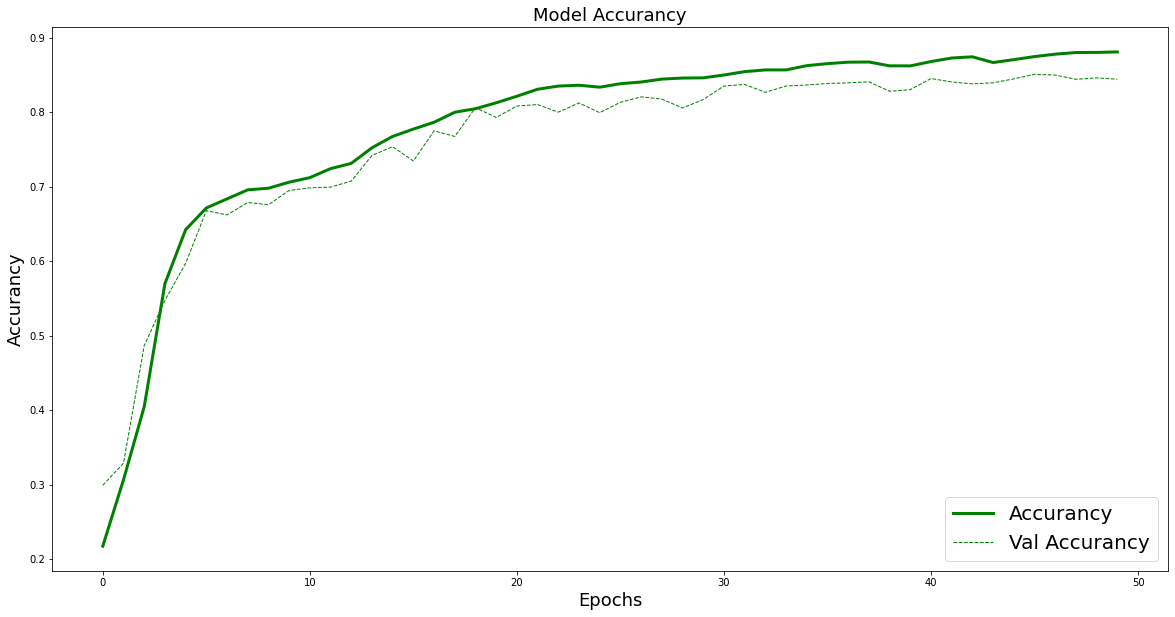

In [15]:
plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'],color='green',linewidth=3,label="Accurancy")
plt.plot(history.history['val_accuracy'],color='green',linewidth=1,linestyle="--",label="Val Accurancy")
plt.title("Model Accurancy",fontsize=18)
plt.xlabel("Epochs",fontsize=18)
plt.ylabel("Accurancy",fontsize=18)
plt.rcParams.update({'font.size': 20})
plt.legend(loc=4, prop={'size': 20})

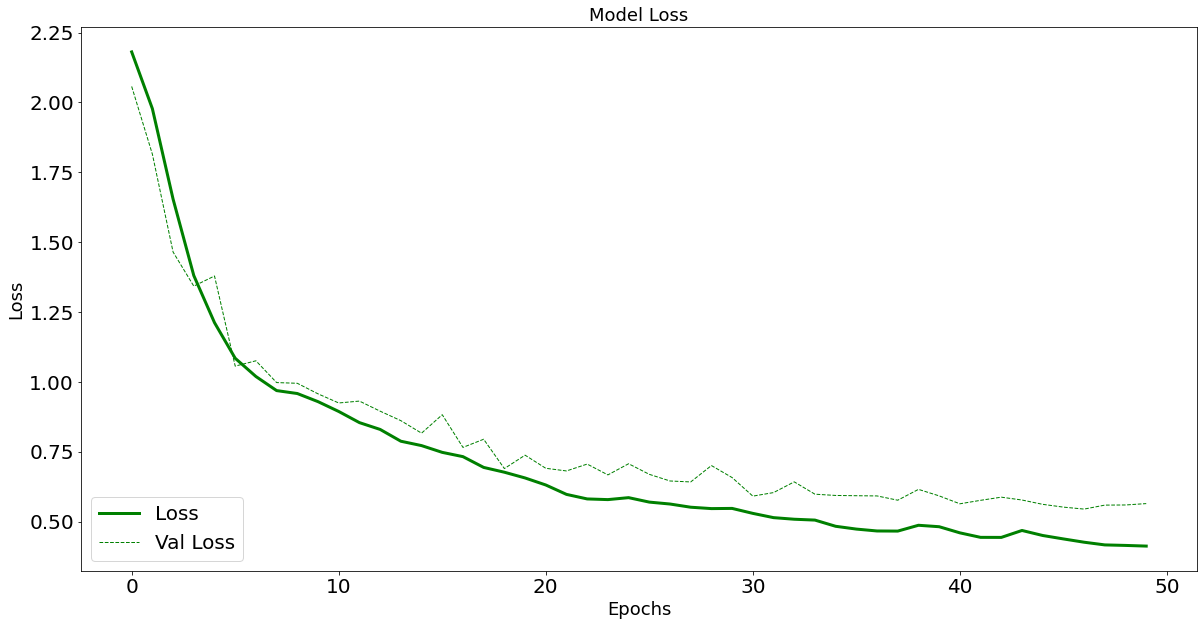

In [16]:
plt.figure(figsize=(20,10))
plt.plot(history.history['loss'],color='green',linewidth=3,label="Loss")
plt.plot(history.history['val_loss'],color='green',linewidth=1,linestyle="--",label="Val Loss")
plt.title("Model Loss",fontsize=18)
plt.xlabel("Epochs",fontsize=18)
plt.ylabel("Loss",fontsize=18)
plt.rcParams.update({'font.size': 20})
plt.legend(loc=3, prop={'size': 20})

In [17]:
def pred_img(img):
    array_img = np.array(img).reshape(1,128,128,1)
    y_pred = model.predict(array_img)
    y_pred_argmax=np.argmax(y_pred_a, axis=3)
    pred_img  = y_pred_argmax[0, :, :]
    return pred_img

In [18]:
def pred_img(pict):
    array_img = np.array(pict).reshape(1,128,128,1)
    y_pred = model.predict(array_img)
    y_pred_argmax=np.argmax(y_pred, axis=3)
    pred_img  = y_pred_argmax[0, :, :]
    return pred_img

In [77]:
# My testing folder
img_h = 128
img_w = 128

lc = "test/*"
folder_train = sorted(glob.glob(lc))
lca = "testannot/*"
folder_mask = sorted(glob.glob(lca))

testing_img = []
testing_masks = []

for loc in folder_train:
    img = cv2.imread(loc, 0)
    img_size = cv2.resize(img, (img_h, img_w))
    testing_img.append(img_size)

for loca in folder_mask:
    imga = cv2.imread(loca, 0)
    img_sizea = cv2.resize(imga, (img_h, img_w))
    testing_masks.append(img_sizea)

testing_img = np.array(testing_img)
testing_masks = np.array(testing_masks)
testing_img = np.expand_dims(testing_img, axis=3)
testing_img = normalize(testing_img, axis=1)

test_masks_input = np.expand_dims(testing_masks, axis=3)

testing_X = testing_img
testing_Y = test_masks_input

n_class = len(np.unique(testing_Y))
test_masks_cat = to_categorical(testing_Y, num_classes=n_class)
y_test_cat = test_masks_cat.reshape((testing_Y.shape[0], testing_Y.shape[1], testing_Y.shape[2], n_class))

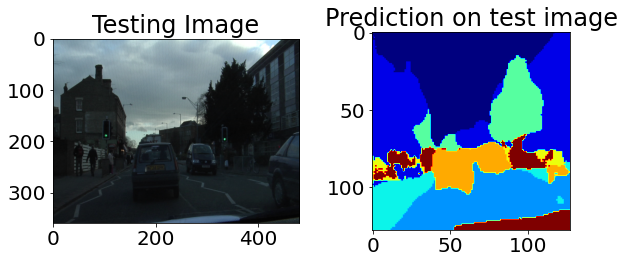

In [102]:
a = random.randint(0,testing_X.shape[0])
predicted_img = pred_img(testing_X[a])
real_img = folder_train[a]
plt.figure(figsize=(15, 8))
plt.subplot(231)
plt.title('Testing Image')
img = cv2.imread(real_img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.subplot(232)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

In [88]:
model.save('my_model.h5')